# AI-3: Natural Language Processing
## PROJECT: IMAGE CAPTIONING FOR ACADEMIC AND SCIENTIFIC PLOTS AND FIGURES

**AI3 Cohort 2**<br/>
**Univ.AI**<br/>
**Instructor**: Prof. Pavlos Protopapas<br />

<hr style="height:2.4pt">

## Names of the people who worked on this project together
**<font color='red'>Bhaskar Bharat, Ekanki Agarwal, Prerna Mahajan and Viraj Kadam</font>**

# Image captioning with visual attention

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Given an academic plot or figure our goal is to generate a caption for the figure and visualize the attention of the model for generation of that caption.

To accomplish this, we'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

When we run the notebook, it loads the pre-formatted SCICAP dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

Through Transfer Learning, we then fine-tune this trained model on the Univ_AI_Dataset. This is a dataset that we have curated using lecture slides from courses AI-1, AI-2, DS-1 and DS-2. Finally, we generate captions on new images using this fine-tuned model and evaluate the performance using [BLEU-4](https://cloud.google.com/translate/automl/docs/evaluate#bleu) scores.

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
import pickle
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## Download and prepare the SCICAP dataset

In [3]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/compact_scicap_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1604.08418v1-Figure2-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1211.5757v2-Figure12-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1608.01842v1-Figure6-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1609.02946v3-Figure2-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1705.00202v2-Figure3-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1107.5953v3-Figure6-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1406.2083v2-Figure4-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1412.8529v2-Figure3-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1205.2632v1-Figure2-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1801.10486v1-Figure11-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/17

In [4]:
!mv "/content/content/scicap_data" "."

In [5]:
!rm -rf "/content/content"

## Limit the size of the training set 
To speed up training for this project, we'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [6]:
num_images = 30000

In [7]:
with open("/content/scicap_data/train_caption.json", 'r') as f:
  train_caption = json.load(f)

In [8]:
train_img_dir = "/content/scicap_data/SciCap-No-Subfig-Img/train/"

train_captions = []
img_name_vector = []

for img in list(train_caption.keys())[:num_images]:
  caption = train_caption[img]
  img_path = train_img_dir+img
  train_captions.append(caption)
  img_name_vector.append(img_path)

<start> the qq-plot of the transmission opportunities distribution <end>


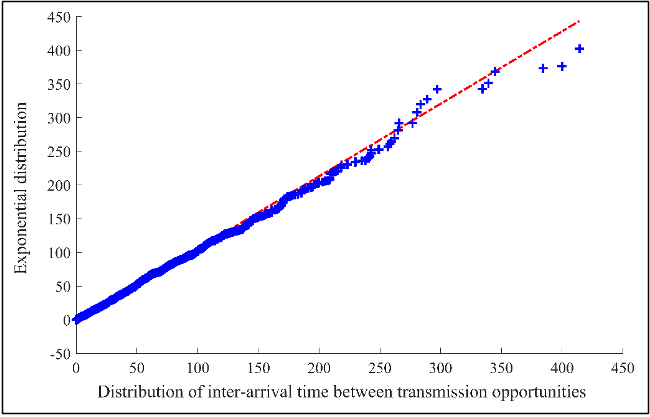

In [9]:
n = 11
print(train_captions[n])
Image.open(img_name_vector[n])

In [10]:
type(Image.open(img_name_vector[n]))

PIL.PngImagePlugin.PngImageFile

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(height=299, width=299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. We use the last convolutional layer because we are using attention in this example. We don't perform this initialization during training because it could become a bottleneck.

* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.


In [12]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

## Caching the features extracted from InceptionV3

We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. This might exceed the memory limitations of Colab (currently 12GB of memory).


In [13]:
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

We will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 10,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [14]:
tmp = []
for ele in train_captions:
  tmp.append(len(ele.split()))
max(tmp)

475

In [15]:
np.mean(np.array(tmp))

26.3484

In [16]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  # return inputs
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 10000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [17]:
# Pickle the config and weights
pickle.dump({'config': tokenizer.get_config(),
             'weights': tokenizer.get_weights()}
            , open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "wb"))

# # Later you can unpickle and use 
# # `config` to create object and 
# # `weights` to load the trained weights. 
# from_disk = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "rb"))
# tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
# # You have to call `adapt` with some dummy data (BUG in Keras)
# tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# tokenizer.set_weights(from_disk['weights'])

In [18]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [19]:
for ele in cap_vector:
  print(ele)
  break

tf.Tensor(
[   4   27  404   23 1534 4243  621    5    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [20]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [96]:
word_2_index = {}
for i, ele in enumerate(tokenizer.get_vocabulary()):
  word_2_index[ele] = i

index_2_word = {v:k for k, v in word_2_index.items()}

In [99]:
with open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/word_2_index.json", "w") as f:
  json.dump(word_2_index, f)

with open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/index_2_word.json", "w") as f:
  json.dump(index_2_word, f)

## Split the data into training and validation

In [21]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [22]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


Our images and captions are ready! Next, let's create a `tf.data` dataset to use for training our model.

In [23]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 256
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [24]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Visual Attention Model

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* We squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here LSTM) attends over the image to predict the next word.

In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm1 = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.lstm2 = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    x = self.lstm1(x)
    output, state, _ = self.lstm2(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [29]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [30]:
optimizer = tf.keras.optimizers.RMSprop()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [31]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [32]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* We extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [33]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [34]:

def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [35]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 4 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.1358
Epoch 1 Batch 50 Loss 2.7507
Epoch 1 Loss 2.842884
Time taken for 1 epoch 202.43 sec

Epoch 2 Batch 0 Loss 2.8693
Epoch 2 Batch 50 Loss 2.5623
Epoch 2 Loss 2.613792
Time taken for 1 epoch 173.56 sec

Epoch 3 Batch 0 Loss 2.3872
Epoch 3 Batch 50 Loss 2.6187
Epoch 3 Loss 2.486507
Time taken for 1 epoch 174.68 sec

Epoch 4 Batch 0 Loss 2.3034
Epoch 4 Batch 50 Loss 2.4989
Epoch 4 Loss 2.382317
Time taken for 1 epoch 206.97 sec

Epoch 5 Batch 0 Loss 2.2295
Epoch 5 Batch 50 Loss 2.3991
Epoch 5 Loss 2.307683
Time taken for 1 epoch 366.42 sec



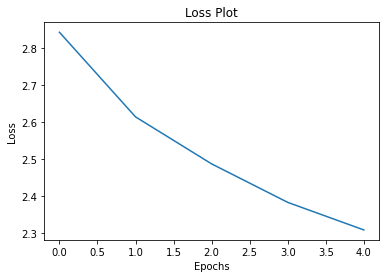

In [36]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [37]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [38]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> duration of [UNK] on livejournal subset of n edges <end>
Prediction Caption: curves for an curve as a displayed ’ s data <end>


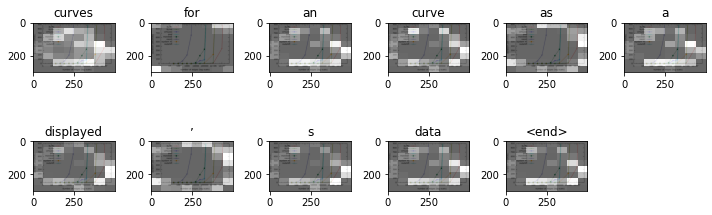

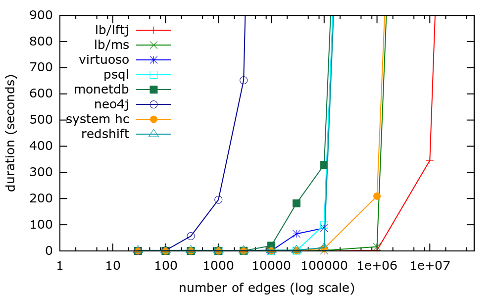

In [39]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [40]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [41]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> graph of error function q <end>
Prediction Caption: link connected seeding by top or this plot of average dead [UNK] results in an very identical approach , b for a function shows the represents the middle 100 algorithms ) with n , , p < 200 <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


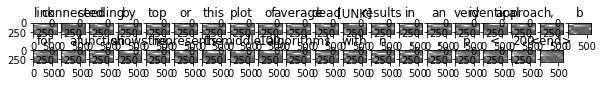

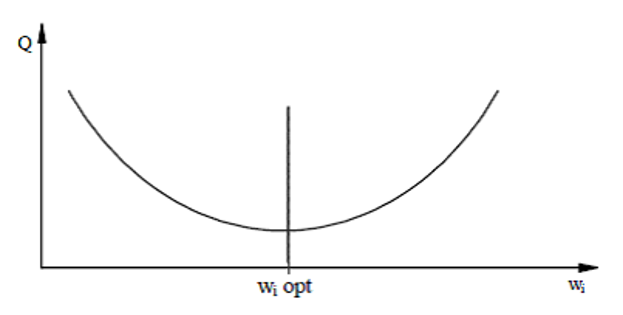

In [42]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [43]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.00579653593359586


In [44]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.05263157894736841
Individual 2-gram: 0.0027027027027027037
Individual 3-gram: 0.0027777777777777775
Individual 4-gram: 0.0028571428571428584


Real Caption: <start> in this plot , we compare the performance between using a [UNK] [UNK] ( environment ) model versus using a simpler random walk ( kalman ) model the results imply that , if the animal indeed moves around based on [UNK] features , a model that [UNK] such features
Prediction Caption: training error on training function of optimum domain the period <end>


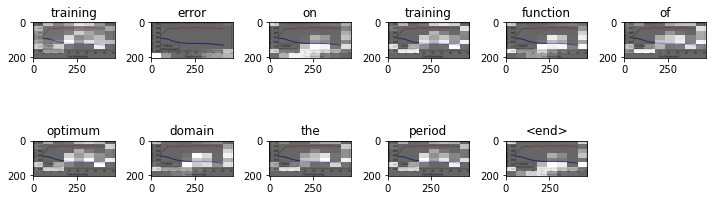

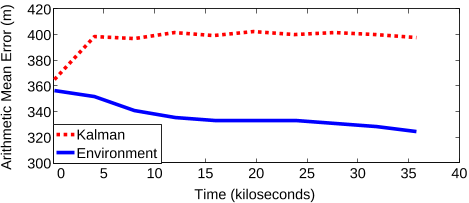

In [45]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [46]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.000508044068632407


In [47]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.004048382289160876
Individual 2-gram: 0.00022491012717560424
Individual 3-gram: 0.0002530238930725549
Individual 4-gram: 0.00028917016351149135


## Transfer Learning and Fine-Tuning the Model on univ_ai_dataset

In [48]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip
   creating: univ_ai_dataset/captions/
  inflating: univ_ai_dataset/captions/captions.json  
  inflating: univ_ai_dataset/captions/captions.txt  
   creating: univ_ai_dataset/images/
  inflating: univ_ai_dataset/images/ekanki-image-1.png  
  inflating: univ_ai_dataset/images/ekanki-image-10.png  
  inflating: univ_ai_dataset/images/ekanki-image-100.png  
  inflating: univ_ai_dataset/images/ekanki-image-11.png  
  inflating: univ_ai_dataset/images/ekanki-image-12.png  
  inflating: univ_ai_dataset/images/ekanki-image-13.png  
  inflating: univ_ai_dataset/images/ekanki-image-14.png  
  inflating: univ_ai_dataset/images/ekanki-image-15.png  
  inflating: univ_ai_dataset/images/ekanki-image-16.png  
  inflating: univ_ai_dataset/images/ekanki-image-17.png  
  inflating: univ_ai_dataset/images/ekanki-image-18.png  
  inflating: univ_ai_dataset/images/ekanki-image-19.png  
  inflating

In [49]:
with open("/content/univ_ai_dataset/univ_caption.json", 'r') as f:
  train_caption = json.load(f)

In [50]:
train_img_dir = "/content/univ_ai_dataset/images/"

train_captions = []
img_name_vector = []

for img in train_caption.keys():
  caption = train_caption[img]
  img_path = train_img_dir+img
  train_captions.append(caption)
  img_name_vector.append(img_path)

<start> roc curves showing discriminatory power of best classifier compared to perfect and random classifiers <end>


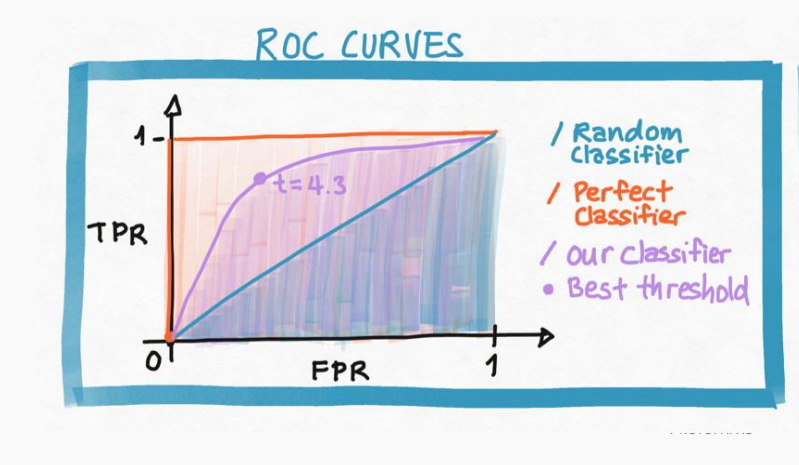

In [51]:
n = 11
print(train_captions[n])
Image.open(img_name_vector[n])

In [52]:
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [53]:
# Create the tokenized vectors
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [54]:
for ele in cap_vector:
  print(ele)
  break

tf.Tensor(
[   4  947  728 3421    1    7    1    1   39    1    7    1    5    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [55]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = 145
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [56]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(145, 145, 5, 5)

In [57]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [58]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [59]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [60]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 4 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.5529
Epoch 1 Loss 2.177089
Time taken for 1 epoch 4.99 sec

Epoch 2 Batch 0 Loss 1.1440
Epoch 2 Loss 1.914701
Time taken for 1 epoch 4.16 sec

Epoch 3 Batch 0 Loss 1.1174
Epoch 3 Loss 1.626348
Time taken for 1 epoch 4.29 sec

Epoch 4 Batch 0 Loss 1.0459
Epoch 4 Loss 1.560877
Time taken for 1 epoch 4.60 sec

Epoch 5 Batch 0 Loss 0.8745
Epoch 5 Loss 1.367432
Time taken for 1 epoch 4.97 sec

Epoch 6 Batch 0 Loss 0.9486
Epoch 6 Loss 1.383402
Time taken for 1 epoch 4.29 sec

Epoch 7 Batch 0 Loss 0.7764
Epoch 7 Loss 1.311912
Time taken for 1 epoch 4.11 sec

Epoch 8 Batch 0 Loss 0.8998
Epoch 8 Loss 1.252717
Time taken for 1 epoch 4.69 sec

Epoch 9 Batch 0 Loss 0.7121
Epoch 9 Loss 1.152047
Time taken for 1 epoch 4.55 sec

Epoch 10 Batch 0 Loss 0.7709
Epoch 10 Loss 1.089520
Time taken for 1 epoch 4.17 sec



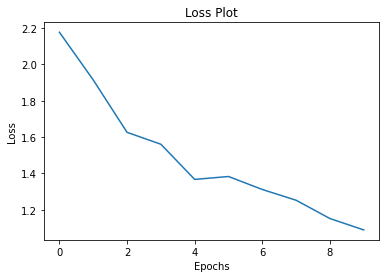

In [61]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [62]:
# Saving fine-tuned model weights
encoder.save_weights("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/encoder_weights.ckpt")
decoder.save_weights("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/decoder_weights.ckpt")

## Predictions on the Validation set from univ_ai_dataset

### Image #1

Real Caption: <start> frequency distribution of residuals for both linear and polynomial regression <end>
Prediction Caption: plot for 5000 and visualize relationship between y for 0 and [UNK] <end>


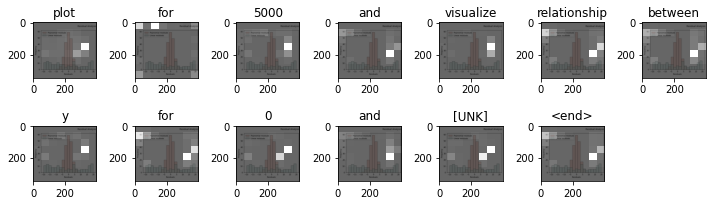

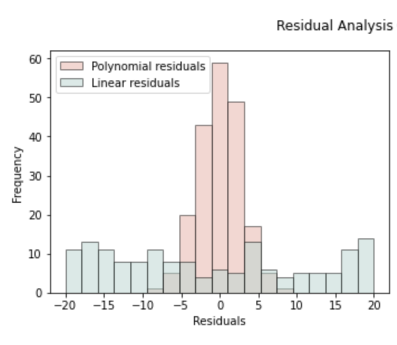

In [63]:
# captions on the validation set
id = 0
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[id] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [64]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.020255986027125642


In [65]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.16666666666666669
Individual 2-gram: 0.009090909090909096
Individual 3-gram: 0.010000000000000004
Individual 4-gram: 0.011111111111111112


### Image #2

Real Caption: <start> plot showing accuracy vs training image per class comparison for different proposed convolution neural network models <end>
Prediction Caption: plot showing the iris dataset <end>


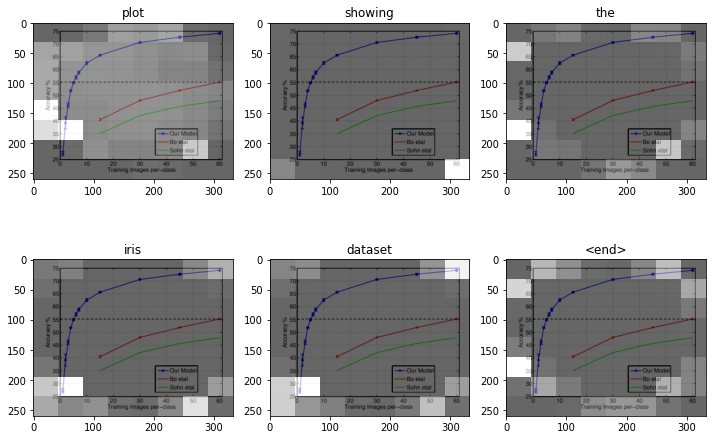

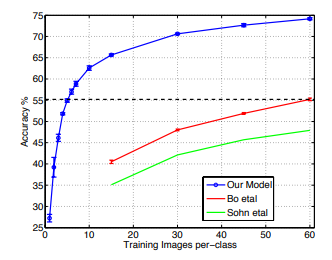

In [66]:
# captions on the validation set
id = 1
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[id] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [67]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.0125896694397049


In [68]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.044321263344933554
Individual 2-gram: 0.027700789590583468
Individual 3-gram: 0.0036934386120777954
Individual 4-gram: 0.005540157918116694


### Image #3

Real Caption: <start> [UNK] of market value in the english [UNK] [UNK] <end>
Prediction Caption: [UNK] and graph <end>


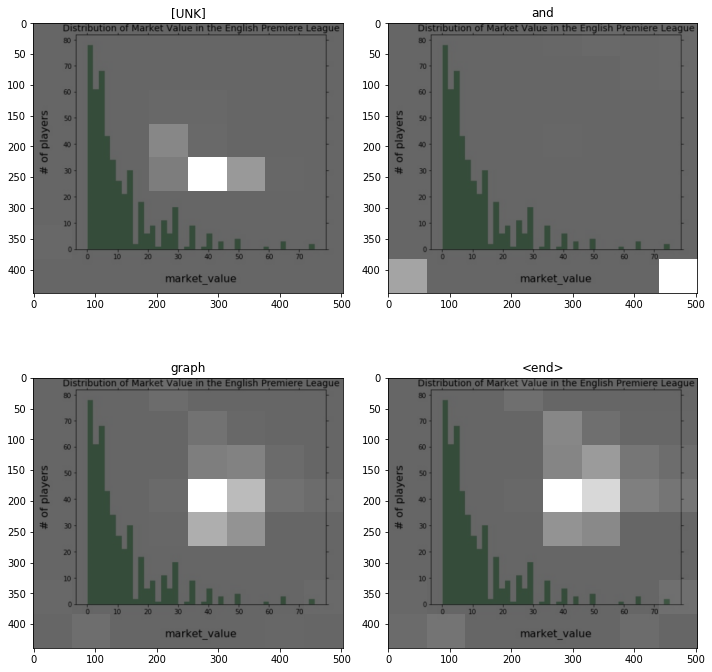

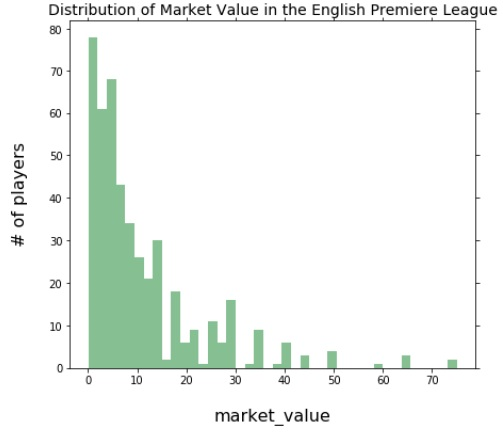

In [69]:
# captions on the validation set
id = 2
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[id] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [70]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.015377056977980369


In [71]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.045111761078870896
Individual 2-gram: 0.006766764161830636
Individual 3-gram: 0.013533528323661273
Individual 4-gram: 0.013533528323661273


### Image #4

Real Caption: <start> plot showing autoencoders model training vs validation loss with respect to number of epochs <end>
Prediction Caption: plot showing comparison of regularization distribution using predict its mse by sales distribution by artificial gaussian and [UNK] [UNK] <end>


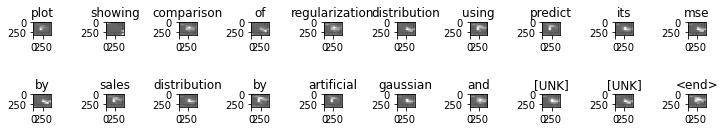

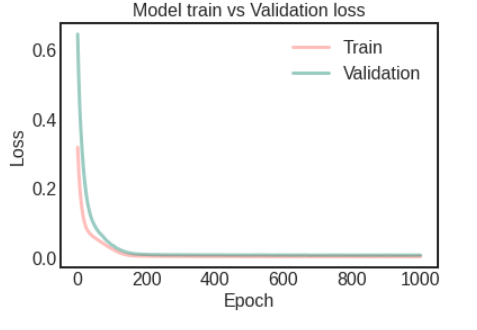

In [72]:
# captions on the validation set
id = 3
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[id] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [73]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.023830412565256146


In [74]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.15789473684210523
Individual 2-gram: 0.05555555555555554
Individual 3-gram: 0.005882352941176469
Individual 4-gram: 0.006250000000000002


### Image #5

Real Caption: <start> green data points refer to class 0 and orange points refer class 1 while red and blue curves are decision boundaries obtained using unregularized and regularized logistic regressions respectively <end>
Prediction Caption: [UNK] [UNK] users having r2 for nn model for cn of imagenet normal update by blue bands of original and noisy convolutional networks for the dropout line where non modifying references <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


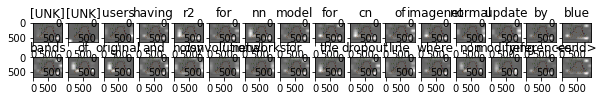

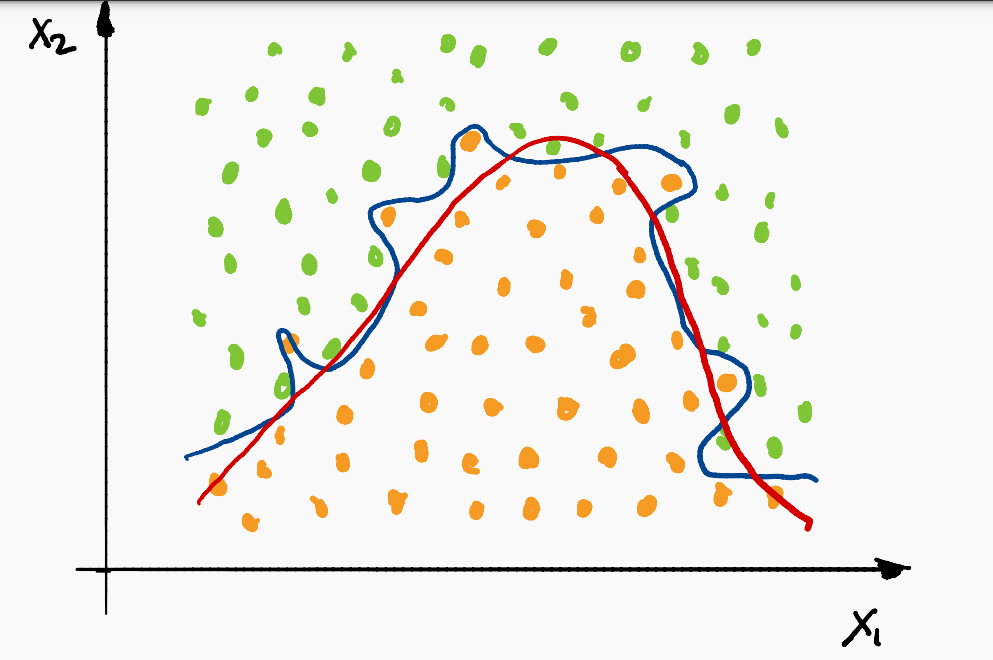

In [75]:
# captions on the validation set
id = 4
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[id] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [76]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.007173775053353474


In [77]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.06451612903225806
Individual 2-gram: 0.003333333333333334
Individual 3-gram: 0.003448275862068966
Individual 4-gram: 0.0035714285714285726


## Try it on your own images

For fun, below we've provided a method that you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: performance of different proposed neural network model with fully neural network model for isotropic network model <end>


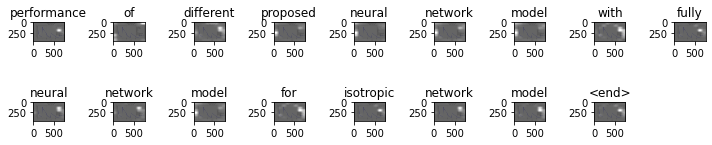

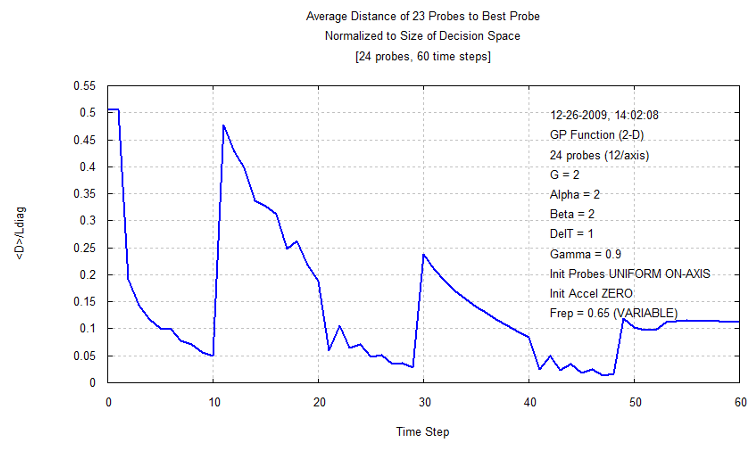

In [78]:
test_dir = "/content/scicap_data/SciCap-No-Subfig-Img/test/"
img_name = "1001.0317v2-Figure7-1.png"

image_path = test_dir + img_name

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## BUILDING A WEB APP USING STREAMLIT

In [80]:
!pip install streamlit -q

     |████████████████████████████████| 9.1 MB 9.0 MB/s 
     |████████████████████████████████| 4.3 MB 54.6 MB/s 
     |████████████████████████████████| 232 kB 65.7 MB/s 
     |████████████████████████████████| 111 kB 61.2 MB/s 
     |████████████████████████████████| 181 kB 5.5 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 164 kB 58.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 133 kB 68.8 MB/s 
     |████████████████████████████████| 132 kB 72.1 MB/s 
     |████████████████████████████████| 793 kB 72.2 MB/s 
     |████████████████████████████████| 428 kB 68.3 MB/s 
     |████████████████████████████████| 381 kB 57.4 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.6.4 requir

In [108]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pickle

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

st.title('IMAGE CAPTIONING WITH VISUAL ATTENTION')

@st.cache(allow_output_mutation=True)
def load_model():
  # Load the saved model stored at checkpoint_filepath
  ENCODER_WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/encoder_weights.ckpt"
  DECODER_WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/decoder_weights.ckpt"

  # Recreate the exact same model, including its weights and the optimizer

  ##########################################################################
  ################  BahdanauAttention ######################################
  ##########################################################################
  class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
      super(BahdanauAttention, self).__init__()
      self.W1 = tf.keras.layers.Dense(units)
      self.W2 = tf.keras.layers.Dense(units)
      self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
      # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

      # hidden shape == (batch_size, hidden_size)
      # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
      hidden_with_time_axis = tf.expand_dims(hidden, 1)

      # attention_hidden_layer shape == (batch_size, 64, units)
      attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                          self.W2(hidden_with_time_axis)))

      # score shape == (batch_size, 64, 1)
      # This gives you an unnormalized score for each image feature.
      score = self.V(attention_hidden_layer)

      # attention_weights shape == (batch_size, 64, 1)
      attention_weights = tf.nn.softmax(score, axis=1)

      # context_vector shape after sum == (batch_size, hidden_size)
      context_vector = attention_weights * features
      context_vector = tf.reduce_sum(context_vector, axis=1)

      return context_vector, attention_weights
    
  #############################################################################
  ######################  CNN_Encoder  #########################################
  #############################################################################
  class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
  #############################################################################
  ######################  RNN_Decoder  #########################################
  #############################################################################
  class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
      super(RNN_Decoder, self).__init__()
      self.units = units

      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.lstm1 = tf.keras.layers.LSTM(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
      self.lstm2 = tf.keras.layers.LSTM(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
      self.fc1 = tf.keras.layers.Dense(self.units)
      self.fc2 = tf.keras.layers.Dense(vocab_size)

      self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
      # defining attention as a separate model
      context_vector, attention_weights = self.attention(features, hidden)

      # x shape after passing through embedding == (batch_size, 1, embedding_dim)
      x = self.embedding(x)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

      # passing the concatenated vector to the LSTM
      x = self.lstm1(x)
      output, state, _ = self.lstm2(x)

      # shape == (batch_size, max_length, hidden_size)
      x = self.fc1(output)

      # x shape == (batch_size * max_length, hidden_size)
      x = tf.reshape(x, (-1, x.shape[2]))

      # output shape == (batch_size * max_length, vocab)
      x = self.fc2(x)

      return x, state, attention_weights

    def reset_state(self, batch_size):
      return tf.zeros((batch_size, self.units))
  
  ##############################################################################
  ####################  OBJECT INSTANTIATION  ##################################
  ##############################################################################
  embedding_dim = 256
  units = 512
  vocab_size = 10000
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)

  encoder.load_weights(ENCODER_WEIGHTS_PATH)
  decoder.load_weights(DECODER_WEIGHTS_PATH)

  return encoder, decoder

with st.spinner('Model is being loaded..'):
  encoder, decoder = load_model()

def save_uploadedfile(uploadedfile):
  dir = "/content/data/" + uploadedfile.name
  os.mkdir(dir)
  with open(dir, "wb") as f:
    f.write(uploadedfile.getbuffer())
  return st.success("Saved File:{} to Data".format(uploadedfile.name))

st.set_option('deprecation.showfileUploaderEncoding', False)
file = st.file_uploader("Upload Image", type=["png"])
if file is not None:
  save_uploadedfile(file)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(height=299, width=299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def import_and_predict(image, encoder, decoder, word_2_index, index_2_word):
  max_length=50
  attention_features_shape=64

  # class CustomUnpickler(pickle.Unpickler):

  #   def find_class(self, module, name):
  #       if name == 'standardize':
  #           from settings import standardize
  #           return standardize
  #       return super().find_class(module, name)
  
  # from_disk = CustomUnpickler(open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "rb")).load()

  # from_disk = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "rb"))
  # tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
  # # You have to call `adapt` with some dummy data (BUG in Keras)
  # tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
  # tokenizer.set_weights(from_disk['weights'])

  # # Create mappings for words to indices and indices to words.
  # word_to_index = tf.keras.layers.StringLookup(
  #     mask_token="",
  #     vocabulary=tokenizer.get_vocabulary())
  # index_to_word = tf.keras.layers.StringLookup(
  #     mask_token="",
  #     vocabulary=tokenizer.get_vocabulary(),
  #     invert=True)

  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0)

  image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
  new_input = image_model.input
  hidden_layer = image_model.layers[-1].output

  image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                -1,
                                                img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)



  dec_input = tf.expand_dims([word_2_index['<start>']], 0)
  result = []

  for i in range(max_length):
      predictions, hidden, attention_weights = decoder(dec_input,
                                                        features,
                                                        hidden)

      attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

      predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
      predicted_word = tf.compat.as_text(index_2_word[predicted_id].numpy())
      result.append(predicted_word)

      if predicted_word == '<end>':
          return result, attention_plot

      dec_input = tf.expand_dims([predicted_id], 0)

  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot

if file is None:
  st.write("Please upload an image file")
else:
  image = Image.open(file)
  st.image(image, use_column_width=True)

  # from_disk = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "rb"))
  # tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
  # # You have to call `adapt` with some dummy data (BUG in Keras)
  # tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
  # tokenizer.set_weights(from_disk['weights'])

  with open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/word_2_index.json", "r") as f:
    word_2_index = json.load(f)
  
  with open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/index_2_word.json", "r") as f:
    index_2_word = json.load(f)

  file_path = "/content/data/"+file.name
  result, attention_plot = import_and_predict(file_path, encoder, decoder, word_2_index, index_2_word)

  msg = f"Prediction Caption: {' '.join(result)}"
  st.subheader(msg)

  st.subheader("VISUAL ATTENTION")

  st.image(plot_attention(file_path, result, attention_plot), use_column_width=True)
  # st.write(prediction)
  # st.write(score)
  # print(
  # "This image most likely belongs to {} with a {:.2f} percent confidence."
  # .format(class_names[np.argmax(score)], 100 * np.max(score)))

Overwriting app.py


In [109]:
!streamlit run app.py & npx localtunnel --port 8501

2022-06-19 17:08:57.241 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
npx: installed 22 in 2.233s
your url is: https://floppy-radios-exist-35-247-56-51.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.247.56.51:8501

2022-06-19 17:09:40.068804: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-19 17:09:56.575 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/scriptrunner/script_runner.py", line 554, in _run_script
    exec(code, module.__dict__)
  File "app.py", line 156, in <module>
    save_uploadedfile(file)
  File "app.py", line 148, in save_uploadedfile
    os.mkdir(dir)
FileNotFoundError: [Errno 2] No such file or directory: '/content/data/ekanki-image-2.png'
  Stopping...
^C
